# Starting the analysis to choose the algorithm

## Importing the initial Libs 

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycaret as pc
sns.set_theme()

## Reading the Data

In [85]:
df_mensal = pd.read_excel('../data/df_mensal.xlsx', engine='openpyxl')

In [86]:
taxas_de_juros = pd.read_excel('../data/taxas_de_juros.xlsx', engine='openpyxl')

In [87]:
usd_brl = pd.read_excel('../data/USD_BRL Dados Históricos.xlsx', engine='openpyxl')

## PreProcess of the Data

### df_mensal

In [88]:
df_mensal.head()

,DateTime,IPCA ocorrido,Variação Petroleo,Taxa de desocupação – desemprego,IBC-Br - atividade econômica
0,2013-01-01,6.15,1.33,NaN,NaN
1,2013-02-01,6.31,-0.57,NaN,NaN
2,2013-03-01,6.59,-4.36,NaN,NaN
3,2013-04-01,6.49,-2.54,NaN,NaN
4,2013-05-01,6.50,1.84,NaN,NaN


In [89]:
df_mensal['DateTime'] = pd.to_datetime(df_mensal['DateTime'])

df_mensal.set_index('DateTime', inplace=True)

df_diario = df_mensal.resample('D').ffill()

df_diario.reset_index(inplace=True)

In [90]:
df_diario.head()

,DateTime,IPCA ocorrido,Variação Petroleo,Taxa de desocupação – desemprego,IBC-Br - atividade econômica
0,2013-01-01,6.15,1.33,NaN,NaN
1,2013-01-02,6.15,1.33,NaN,NaN
2,2013-01-03,6.15,1.33,NaN,NaN
3,2013-01-04,6.15,1.33,NaN,NaN
4,2013-01-05,6.15,1.33,NaN,NaN


### taxas_de_juros

In [91]:
taxas_de_juros['DateTime'] = pd.to_datetime(taxas_de_juros['DateTime'])

### usd_brl

In [92]:
usd_brl['DateTime'] = pd.to_datetime(usd_brl['DateTime'])

### Merging df's

In [93]:
mensal_and_juros = pd.merge(df_diario, taxas_de_juros, on='DateTime')

In [94]:
mensal_and_juros.head()

,DateTime,IPCA ocorrido,Variação Petroleo,Taxa de desocupação – desemprego,IBC-Br - atividade econômica,Selic,Taxa Americana
0,2013-12-05,5.91,5.34,6.3,NaN,10.0,0.09
1,2013-12-06,5.91,5.34,6.3,NaN,10.0,0.09
2,2013-12-07,5.91,5.34,6.3,NaN,10.0,0.09
3,2013-12-08,5.91,5.34,6.3,NaN,10.0,0.09
4,2013-12-09,5.91,5.34,6.3,NaN,10.0,0.09


In [95]:
mensal_and_juros.shape

(3588, 7)

In [96]:
df = pd.merge(mensal_and_juros, usd_brl, on='DateTime')

In [97]:
df.head()

,DateTime,IPCA ocorrido,Variação Petroleo,Taxa de desocupação – desemprego,IBC-Br - atividade econômica,Selic,Taxa Americana,Var%
0,2013-12-06,5.91,5.34,6.3,NaN,10.0,0.09,0.0111
1,2013-12-07,5.91,5.34,6.3,NaN,10.0,0.09,0.0060
2,2013-12-08,5.91,5.34,6.3,NaN,10.0,0.09,0.0069
3,2013-12-09,5.91,5.34,6.3,NaN,10.0,0.09,-0.0009
4,2013-12-11,5.91,5.34,6.3,NaN,10.0,0.08,0.0011


## Dev the model

### Finding the best model

In [98]:
from pycaret.regression import setup, compare_models

setup(df, target='Selic')

best_model = compare_models()

,Description,Value
0,Session id,4332
1,Target,Selic
2,Target type,Regression
3,Original data shape,"(2557, 8)"
4,Transformed data shape,"(2557, 10)"
5,Transformed train set shape,"(1789, 10)"
6,Transformed test set shape,"(768, 10)"
7,Numeric features,6
8,Date features,1
9,Rows with missing values,0.8%


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0273,0.0126,0.1080,0.9992,0.0133,0.0039,0.0840
rf,Random Forest Regressor,0.0374,0.0164,0.1231,0.9990,0.0163,0.0058,0.1440
xgboost,Extreme Gradient Boosting,0.0534,0.0182,0.1282,0.9989,0.0179,0.0084,0.0740
lightgbm,Light Gradient Boosting Machine,0.0746,0.0198,0.1386,0.9988,0.0194,0.0117,0.1250
dt,Decision Tree Regressor,0.0257,0.0227,0.1466,0.9986,0.0193,0.0038,0.0170
gbr,Gradient Boosting Regressor,0.1299,0.0436,0.2072,0.9974,0.0284,0.0200,0.0930
ada,AdaBoost Regressor,0.5399,0.3912,0.6251,0.9764,0.0910,0.0856,0.0670
knn,K Neighbors Regressor,0.2884,0.3958,0.6188,0.9763,0.0820,0.0454,0.0220
lar,Least Angle Regression,1.4748,3.4349,1.8508,0.7935,0.2351,0.2300,0.0180
br,Bayesian Ridge,1.4752,3.4343,1.8506,0.7935,0.2353,0.2304,0.0150


### Extra Trees Regressor

In [99]:
df.drop(['DateTime'], axis=1, inplace=True)
df.head()

,IPCA ocorrido,Variação Petroleo,Taxa de desocupação – desemprego,IBC-Br - atividade econômica,Selic,Taxa Americana,Var%
0,5.91,5.34,6.3,NaN,10.0,0.09,0.0111
1,5.91,5.34,6.3,NaN,10.0,0.09,0.0060
2,5.91,5.34,6.3,NaN,10.0,0.09,0.0069
3,5.91,5.34,6.3,NaN,10.0,0.09,-0.0009
4,5.91,5.34,6.3,NaN,10.0,0.08,0.0011


In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(strategy='mean')  
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

X = df_imputed.drop('Selic', axis=1)
y = df_imputed['Selic']

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

et = ExtraTreesRegressor(random_state=42)

grid_search = GridSearchCV(estimator=et, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print("Melhores parâmetros: ", best_params)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Melhores parâmetros:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [101]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

best_params = {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

etr = ExtraTreesRegressor(**best_params, random_state=42)

selector = SelectFromModel(estimator=etr).fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

etr.fit(X_train_selected, y_train)

scores = cross_val_score(etr, X_train_selected, y_train, cv=5) 
print(f"Acurácia da validação cruzada: {scores.mean()} (+/- {scores.std() * 2})")

y_pred = etr.predict(X_test_selected)

test_score = etr.score(X_test_selected, y_test)
print(f"Acurácia nos dados de teste: {test_score}")

final_decision = etr.predict(X_test_selected[-1:])
print("Decisão final: ", final_decision)

Acurácia da validação cruzada: 0.9982735573416356 (+/- 0.0011478798216531607)
Acurácia nos dados de teste: 0.9980979593087178
Decisão final:  [13.09615385]


In [102]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

et_model = ExtraTreesRegressor(
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=10,
    n_estimators=200,
    random_state=42  
)

et_model.fit(X_train, y_train)

predictions = et_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)

print("Erro Quadrático Médio (MSE): ", mse)

Erro Quadrático Médio (MSE):  0.03162223196126826


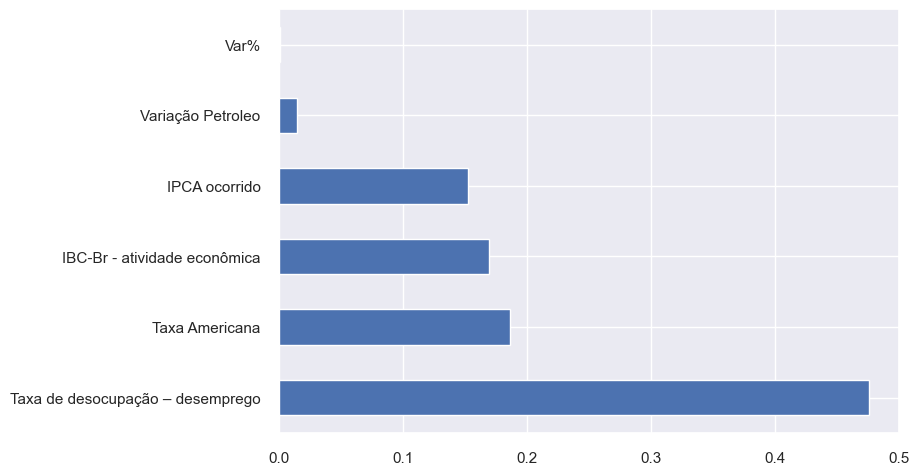

In [103]:
et_model = ExtraTreesRegressor(n_estimators=200, random_state=42)
et_model.fit(X_train, y_train)

feat_importances = pd.Series(et_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [104]:
predictions = et_model.predict(X_test)

comparison_df = pd.DataFrame({'Real Values': y_test, 'Predictions': predictions})

comparison_df

,Real Values,Predictions
2523,13.25,13.25000
1750,2.00,2.00000
2051,6.25,6.25000
393,13.75,13.75000
1472,6.50,6.50000
...,...,...
1703,3.00,2.58375
585,14.25,14.25000
1263,6.50,6.50000
1151,6.50,6.50000


In [105]:
y_train.unique()

array([ 9.25, 13.75, 14.25,  6.5 , 12.25,  5.  ,  7.75,  2.75, 11.75,
        4.25,  3.5 , 10.75,  7.  ,  2.  ,  3.  ,  6.  ,  6.75, 12.75,
       11.  , 10.25, 10.5 ,  2.25,  4.5 , 11.25,  7.5 , 14.  ,  5.25,
        3.75,  5.5 , 10.  , 13.25,  8.25,  6.25, 13.  ])

In [106]:
final_decision = et_model.predict(X_test.iloc[-1:].values)

print("Decisão final: ", final_decision)    

Decisão final:  [13.25]


### Random Forest Regressor	

In [108]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

X = df_imputed.drop('Selic', axis=1)
y = df_imputed['Selic']

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

rf = RandomForestRegressor(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_

print("Melhores parâmetros para RandomForestRegressor: ", best_params_rf)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Melhores parâmetros para RandomForestRegressor:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


In [109]:
rf_model = RandomForestRegressor(**best_params_rf, random_state=42)

rf_model.fit(X_train, y_train)

final_decision_rf = rf_model.predict(X_test.iloc[-1:].values)

print("Decisão final para RandomForestRegressor: ", final_decision_rf)

Decisão final para RandomForestRegressor:  [13.20806372]


In [110]:
from sklearn.feature_selection import SelectFromModel

best_params_rf = {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

rf = RandomForestRegressor(**best_params_rf, random_state=42)

selector = SelectFromModel(estimator=rf).fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

rf.fit(X_train_selected, y_train)

scores = cross_val_score(rf, X_train_selected, y_train, cv=5)
print(f"Acurácia da validação cruzada: {scores.mean()} (+/- {scores.std() * 2})")

y_pred = rf.predict(X_test_selected)

test_score = rf.score(X_test_selected, y_test)
print(f"Acurácia nos dados de teste: {test_score}")

final_decision_rf = rf.predict(X_test_selected[-1:])
print("Decisão final para RandomForestRegressor: ", final_decision_rf)


Acurácia da validação cruzada: 0.9944297737409789 (+/- 0.0033457284570814934)
Acurácia nos dados de teste: 0.9951192268373175
Decisão final para RandomForestRegressor:  [13.09615385]


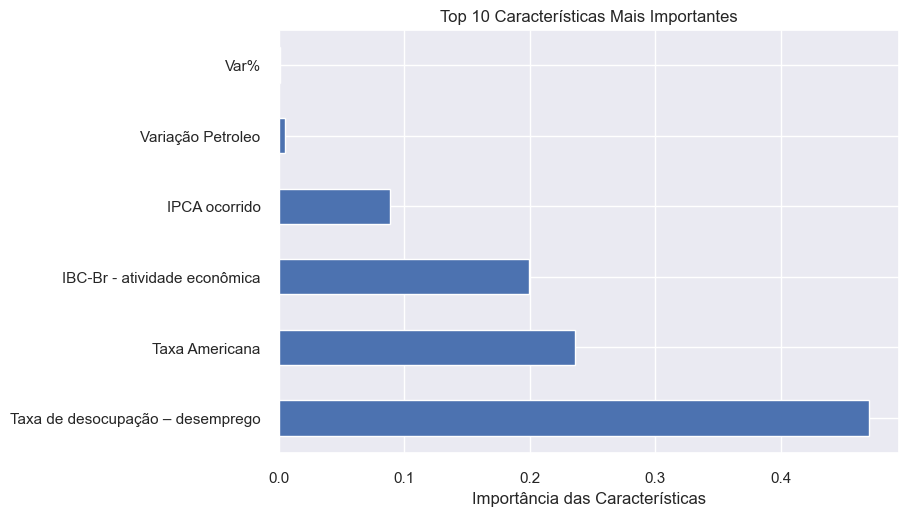

In [111]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

rf_model.fit(X_train, y_train)

feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

top_feat_importances = feat_importances.nlargest(10)

top_feat_importances.plot(kind='barh')
plt.xlabel('Importância das Características')
plt.title('Top 10 Características Mais Importantes')
plt.show()